# Final Project

The Diversity, Equity, and Inclusion (DEI) measures dataset simulates an employee dataset for a company, including sensitive information such as gender, sexual orientation, ethnicity, and disability.

The goal is to apply machine learning techniques to predict who holds managerial positions based on these sensitive features. If certain sensitive features (such as gender, ethnicity, etc.) significantly contribute to predicting managerial roles, it would indicate a potential bias in the system, suggesting that the company's practices may be non-inclusive, inequitable, or unethical. On the other hand, if the prediction becomes difficult or inaccurate, it suggests that the company’s structure is more inclusive, with less reliance on these sensitive attributes in determining managerial positions.

This model can also be used to assess the effectiveness of the company’s efforts to improve DEI, and to identify if certain groups are being left behind in career advancement opportunities.

In [25]:
import pandas as pd
import numpy as np
import itertools
import random
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [26]:
dataset = pd.read_csv('DEI_Dataset.csv')

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  10000 non-null  int64 
 1   Name                10000 non-null  object
 2   Surname             10000 non-null  object
 3   Division            10000 non-null  object
 4   Manager             10000 non-null  object
 5   Gender              10000 non-null  object
 6   Sexual_Orientation  10000 non-null  object
 7   LGBTQ               10000 non-null  object
 8   Indigenous          10000 non-null  object
 9   Ethnicity           10000 non-null  object
 10  Disability          10000 non-null  object
 11  Minority            10000 non-null  object
 12  Veteran             10000 non-null  object
 13  Date of Birth       10000 non-null  object
 14  Age                 10000 non-null  int64 
 15  Preferred Name      10000 non-null  object
 16  Nationality         100

In [28]:
# Fixed code for the functions and variable assignment
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace=False)
    X[indexes] = np.nan
    return X

def add_missing_rows(dataset, amount):
    X = df.copy()
    rows, cols = X.shape
    size = amount if amount >= 1 else int(rows * amount)
    indexes = np.random.choice(rows, size, replace=False) + 0.5
    for i in indexes:
        X.loc[int(i)] = np.full((cols,), np.nan)  # Ensure the index is an integer
    X = X.sort_index().reset_index(drop=True)
    return X

In [29]:
dataset['Division'] = add_missing(dataset['Division'], 0.08)
dataset['Gender'] = add_missing(dataset['Gender'], 0.05)
dataset['Sexual_Orientation'] = add_missing(dataset['Sexual_Orientation'], 0.07)
dataset['Hobbies'] = add_missing(dataset['LGBTQ'], 0.4)
dataset['Preferred Name'] = add_missing(dataset['Preferred Name'], 0.45)
dataset['Date of Birth'] = add_missing(dataset['Date of Birth'], 0.6)
dataset['Age'] = add_missing(dataset['Age'], 0.02)

## Data Visualization

In [30]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  int64  
 1   Name                10000 non-null  object 
 2   Surname             10000 non-null  object 
 3   Division            9200 non-null   object 
 4   Manager             10000 non-null  object 
 5   Gender              9500 non-null   object 
 6   Sexual_Orientation  9300 non-null   object 
 7   LGBTQ               10000 non-null  object 
 8   Indigenous          10000 non-null  object 
 9   Ethnicity           10000 non-null  object 
 10  Disability          10000 non-null  object 
 11  Minority            10000 non-null  object 
 12  Veteran             10000 non-null  object 
 13  Date of Birth       4000 non-null   object 
 14  Age                 9800 non-null   float64
 15  Preferred Name      5500 non-null   object 
 16  Natio

By analyzing the dataset, we identify that there are some missing values. The analysis of the missing values is conducted column by column. The percentage of missing values in the respective columns is as follows:

- Division: 8%

- Gender: 5%

- Sexual_Orientation: 7%

- Hobbies: 40%

- Preferred Name: 45%

- Date of Birth: 60%

To plot where the missing values are located in the feature matrix I use the method msno.matrix(X)

<AxesSubplot: >

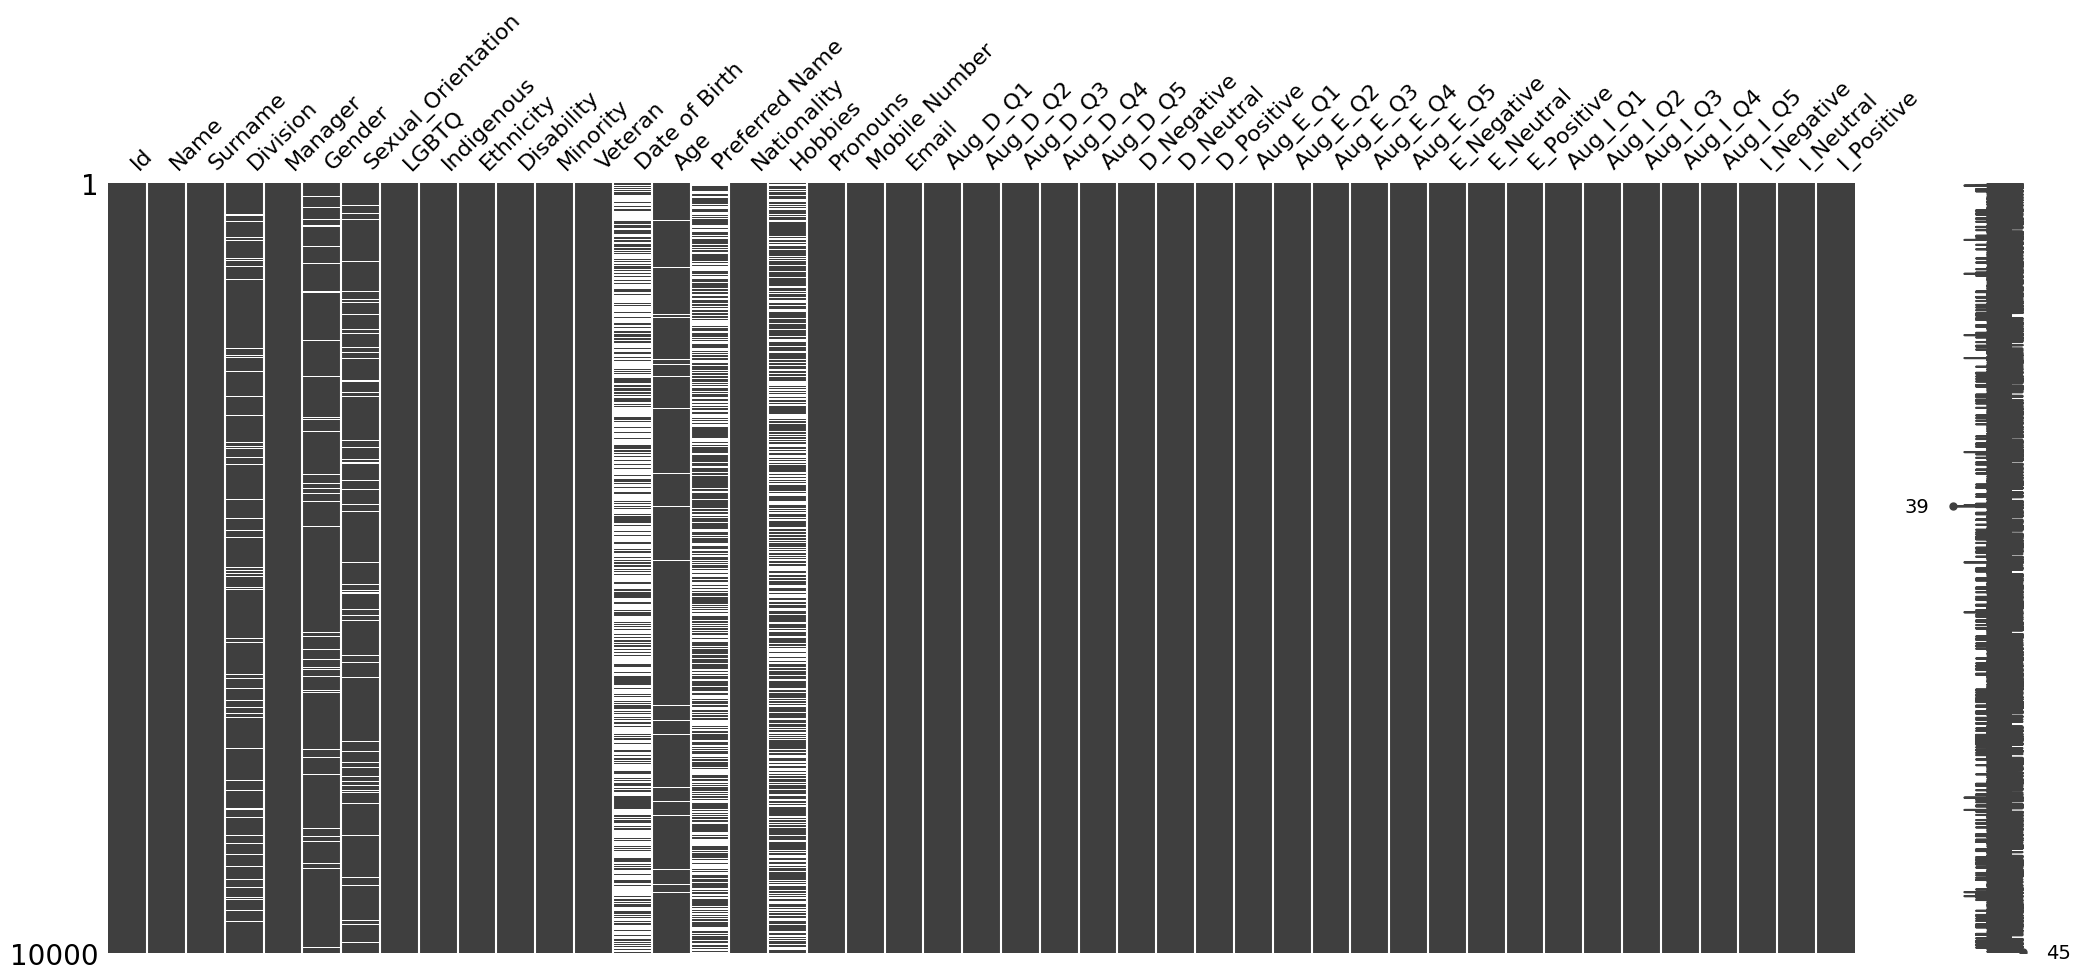

In [31]:
import missingno as msno
msno.matrix(dataset)

The strategy to address the missing values is the following:

- For columns with a percentage of missing values above 30% (Hobbies, Preferred Name, and Date of Birth), the column will be removed.

- For columns with a percentage of missing values below 10% (Division, Gender, and Sexual Orientation), the column will be retained.

Before diving into any operations on the dataset, I want to first visualize and explore all the data to see which features are most correlated with the target variable, which in this case is whether someone is a manager.

To start, I'll look at the distribution of the target column to check if it is balanced or not.

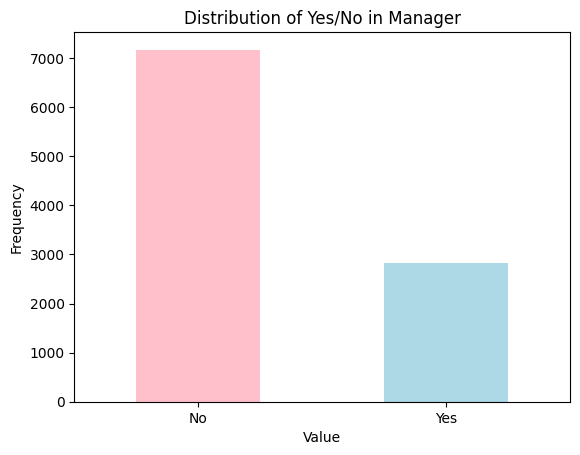

Manager
No     7171
Yes    2829
Name: count, dtype: int64


In [32]:
# Calculate the frequency of values
value_counts = dataset['Manager'].value_counts()

# To create a bar chart based on the ferquency of the string
value_counts.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Distribution of Yes/No in Manager')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# show the result
print(value_counts)

The distribution of the target column is evidently imbalanced, with 28.3% marked as "yes" and 71.8% marked as "no." This imbalance has significant implications for the analysis of the dataset. A model trained on such an imbalanced dataset may predominantly predict the majority class due to its higher frequency.

Moreover, accuracy can be misleading in the context of imbalanced datasets. A model that consistently predicts the majority class may achieve high accuracy but fail to effectively predict the minority class. Thus, relying solely on accuracy as a performance metric is not advisable in this scenario. It is crucial to consider other performance metrics, particularly the F1-Score. The F1-Score is beneficial for imbalanced datasets as it balances precision and recall and is less sensitive to class imbalance compared to accuracy. This metric ensures that the model performs well in identifying both classes, especially the minority class, which requires more attention.

At this point, I want to check out the distribution of both numerical and categorical data. For the numerical data, I'll look at their spreads using histograms.

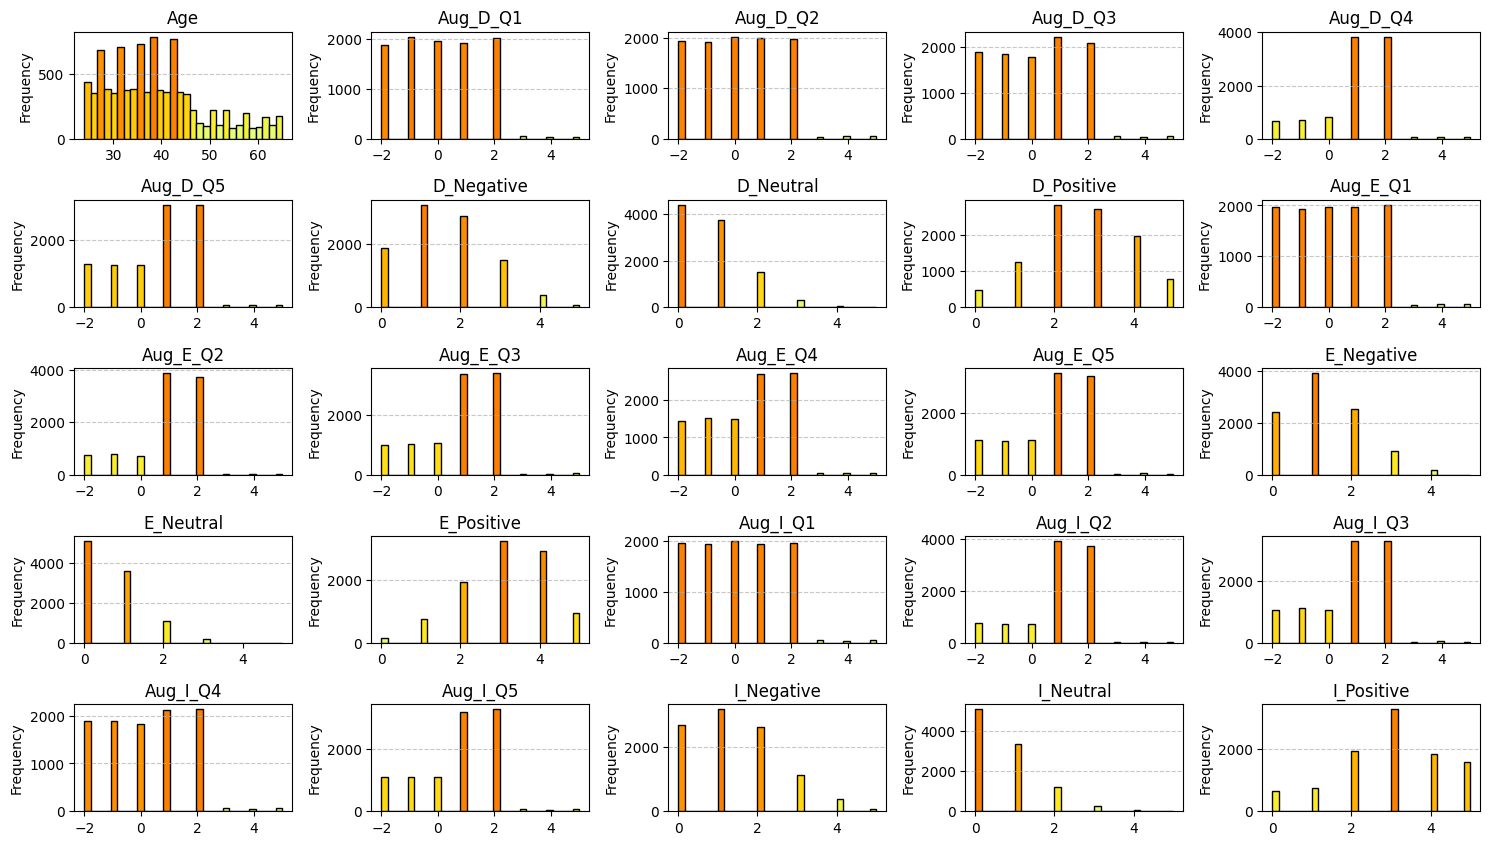

In [33]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Extract numerical columns from the dataset
numerical_columns = dataset.select_dtypes(include='number').drop(columns=['Id'], errors='ignore').columns

# Define the color map 
color_map = cm.Wistia 

# Create subplots 
fig, axes = plt.subplots(nrows=len(numerical_columns) // 5 + 1, ncols=5, figsize=(15, 10))
axes = axes.flatten()

# Iterate over numerical columns and plot histograms
for i, col in enumerate(numerical_columns):
    ax = axes[i]

    # Compute histogram data
    counts, bins, patches = ax.hist(dataset[col], bins=30, edgecolor='black')

    # Normalize the counts to map them to the color gradient
    norm = Normalize(vmin=min(counts), vmax=max(counts))

    # Assign colors based on frequency
    for patch, count in zip(patches, counts):
        patch.set_facecolor(color_map(norm(count)))

    # Set titles and labels
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove empty subplots to avoid extra blank plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

We can make few considerations by looking at the histograms:

- The age distribution is skewed slightly left with most employees between 25 and 45 years old.

- For all the values Aug_* the values are mostly between -2 and 2. 

As for the categorical data, I'll base the graphs on the frequency of the strings that appear in the columns. This way, I can clearly see the most common categories and how they are distributed within the dataset.

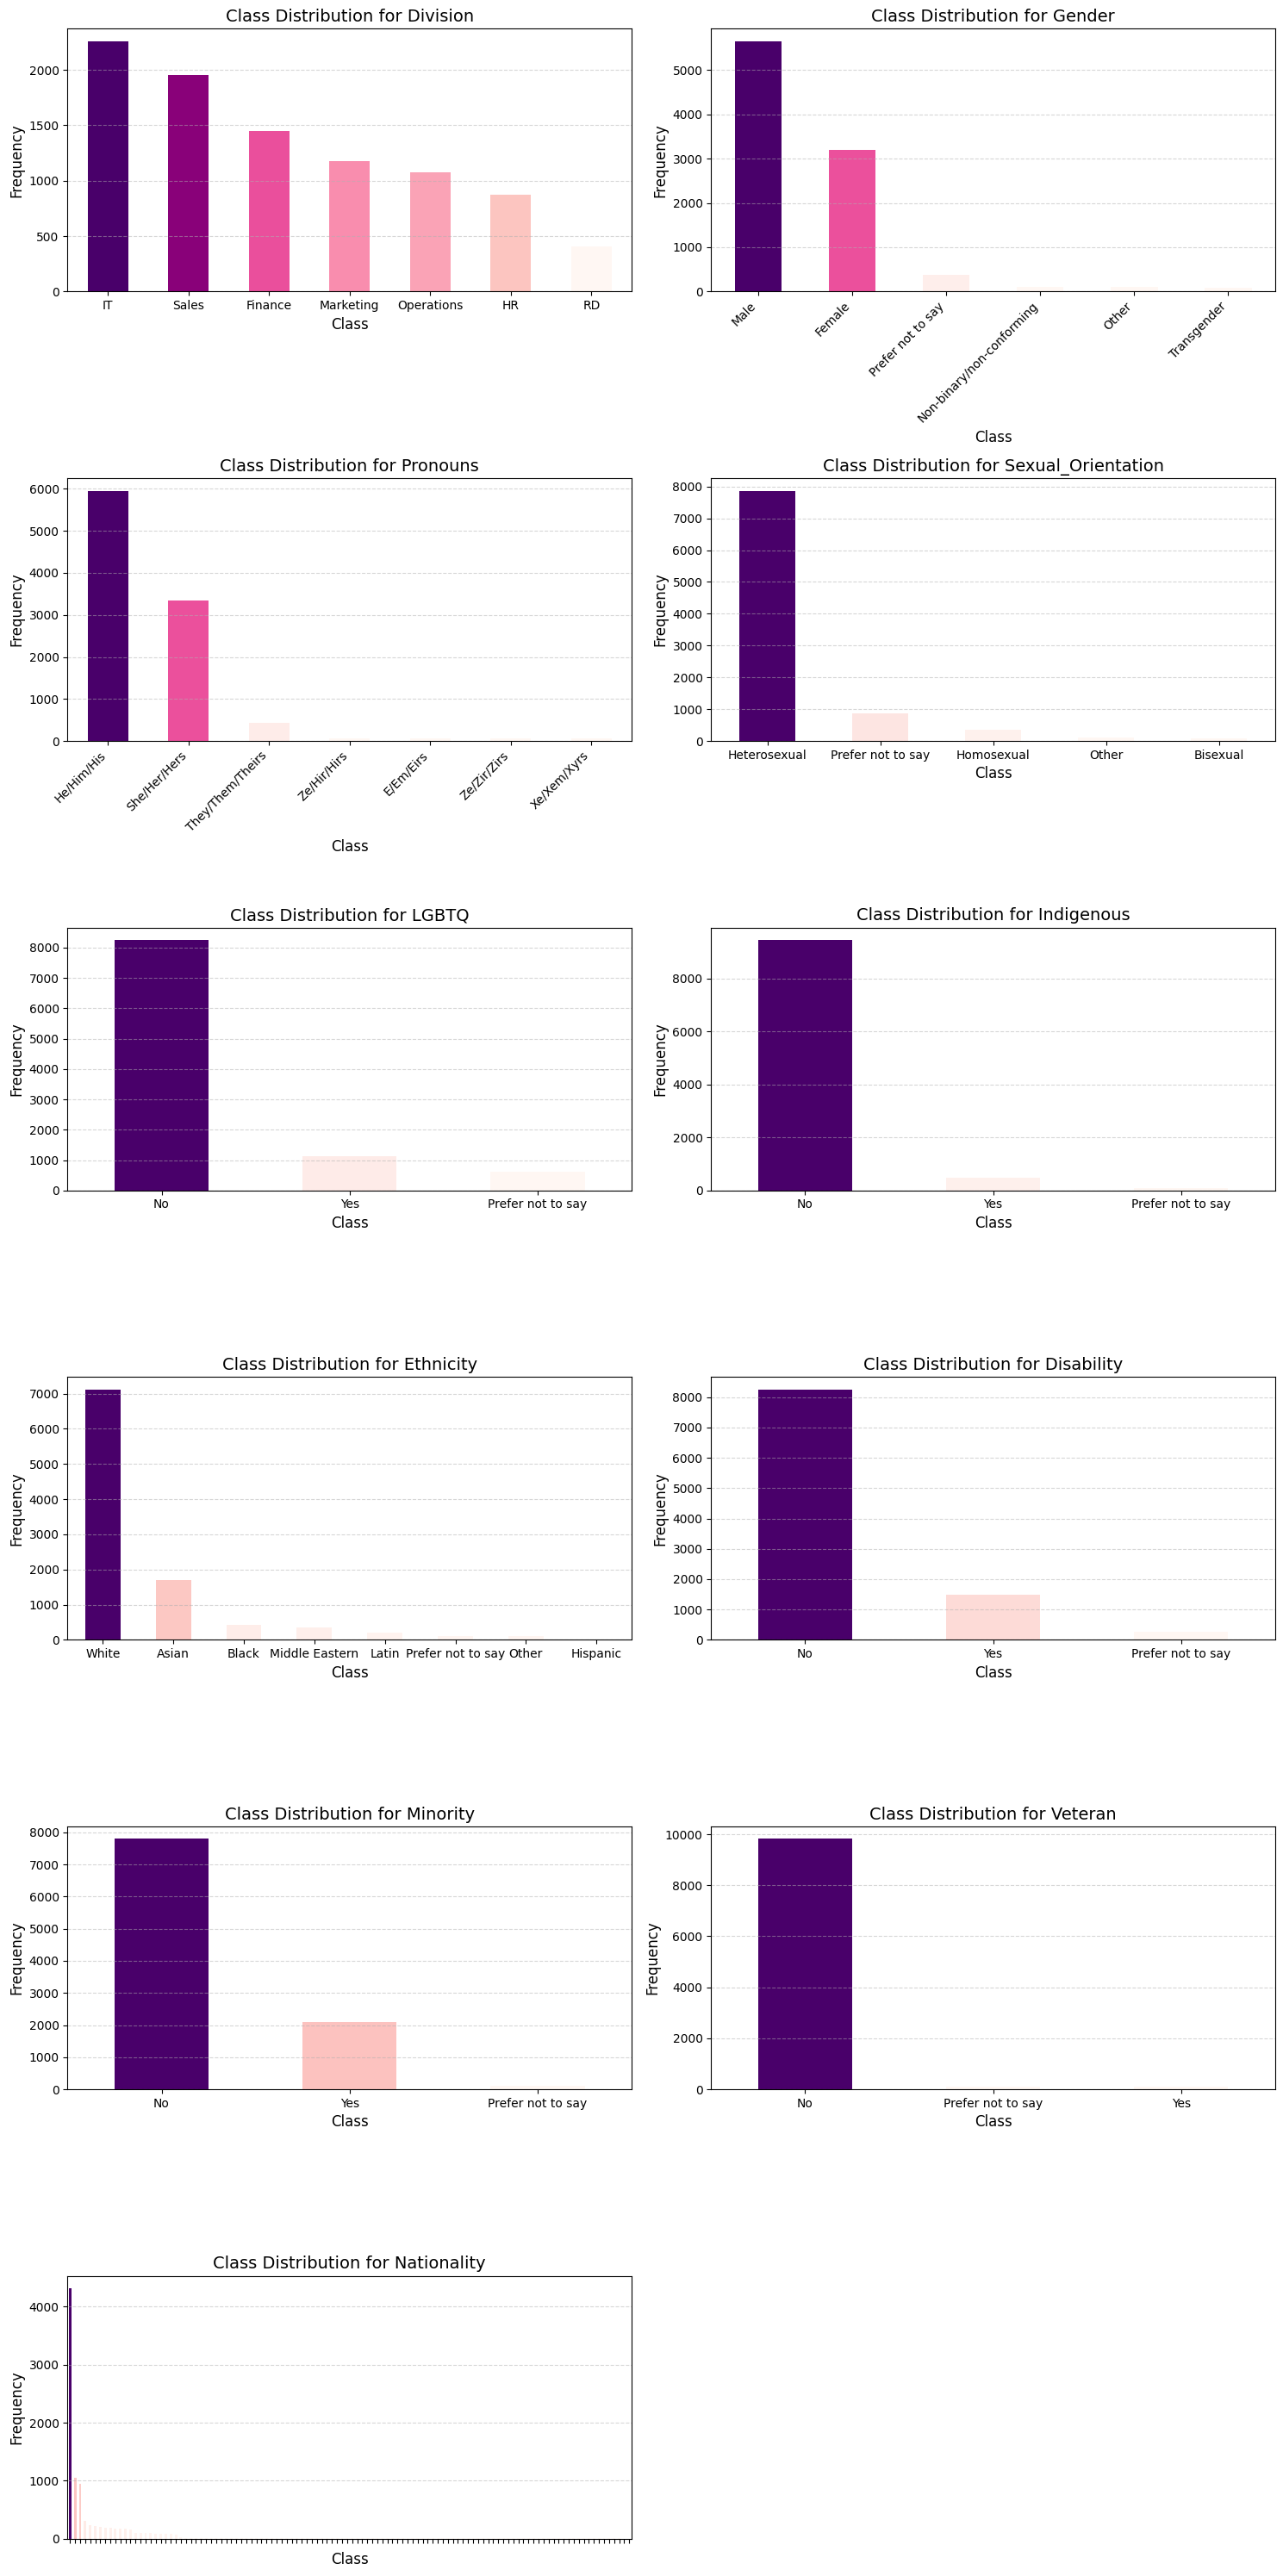

In [34]:
# Define the color map 
color_map = cm.RdPu

# List of columns to plot
columns_to_plot = ["Division", "Gender", "Pronouns", "Sexual_Orientation", "LGBTQ", "Indigenous", 
                   "Ethnicity", "Disability", "Minority", "Veteran", "Nationality"]

# Set the number of rows and columns for the subplots (2 charts per row)
n_cols = 2
n_rows = int(np.ceil(len(columns_to_plot) / n_cols))

# Create a figure and axes for the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the bar charts
for i, col in enumerate(columns_to_plot):
    # Get the count of values in the column
    class_counts = dataset[col].value_counts()

    # Normalize the counts for color mapping
    norm = Normalize(vmin=class_counts.min(), vmax=class_counts.max())

    # Assign colors from the pastel colormap
    colors = [color_map(norm(value)) for value in class_counts]

    # Determine the axis to plot on
    ax = axes[i]
    
    # Create the bar chart with mapped colors
    class_counts.plot(kind='bar', color=colors, ax=ax)
    
    # Add title and labels
    ax.set_title(f'Class Distribution for {col}', fontsize=14)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
    # For 'Gender' and 'Pronouns', rotate x-axis labels
    if col in ["Gender", "Pronouns"]:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

    # For 'Nationality', remove all x-axis labels
    elif col == "Nationality":
        ax.set_xticklabels([])  # Remove all labels on x-axis
    
    # For other columns, keep the default x-axis labels
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=10)
    
    # Add gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Remove empty subplots to avoid blank spaces
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing and to prevent label overlap
plt.tight_layout()

# Show the plots
plt.show()

In [35]:
# Count the occurrences of each category in the 'Veteran' column
veteran_counts = dataset['Veteran'].value_counts()

# Print the counts
print(veteran_counts)

Veteran
No                   9815
Prefer not to say      95
Yes                    90
Name: count, dtype: int64


For these histograms as well, we can make few considerations:

- The Veteran class is severely imbalanced, with only 0.90% of "Yes" compared to 98.1% for "No." Due to this significant imbalance, this feature will be removed.

-  The distributions of Pronouns and Gender are very similar. Therefore, further analysis will be conducted to determine whether they represent the same underlying information. If this is the case, one of the features may be deemed redundant and removed to avoid unnecessary duplication in the dataset.

## Preprocessing

I will now begin modifying the dataset. Preprocessing is the essential first step in machine learning, where raw data is transformed into a suitable format for model training. This process involves handling missing values, encoding categorical variables, and scaling numerical features, ensuring the dataset is ready for effective and efficient model training.

Firstly, I handle missing values and the most common way to handle them is to replacing missing value with the mean (median or most frequent value) or, if it is a small portion of the dataset, dropping rows and columns with missing data.

As we have said before, we start by dropping the columns 

In [36]:
dataset = dataset.dropna(thresh=7000, axis=1) 

Before designing the transformation pipeline, I aim to eliminate columns that are irrelevant to the model and do not provide useful information. The columns to be removed are:

- Id

- Name

- Surname

- Mobile number

- Email

The veteran column will be removed as well, due to its high unbalance (as written above).

In [37]:
useless_columns = ['Id', 'Name', 'Surname', 'Mobile Number', 'Email', "Veteran"]
dataset_cleaned = dataset.drop(columns=useless_columns)

As anticipated, now I'll check if the pronouns column and the gender column represent the same information. 

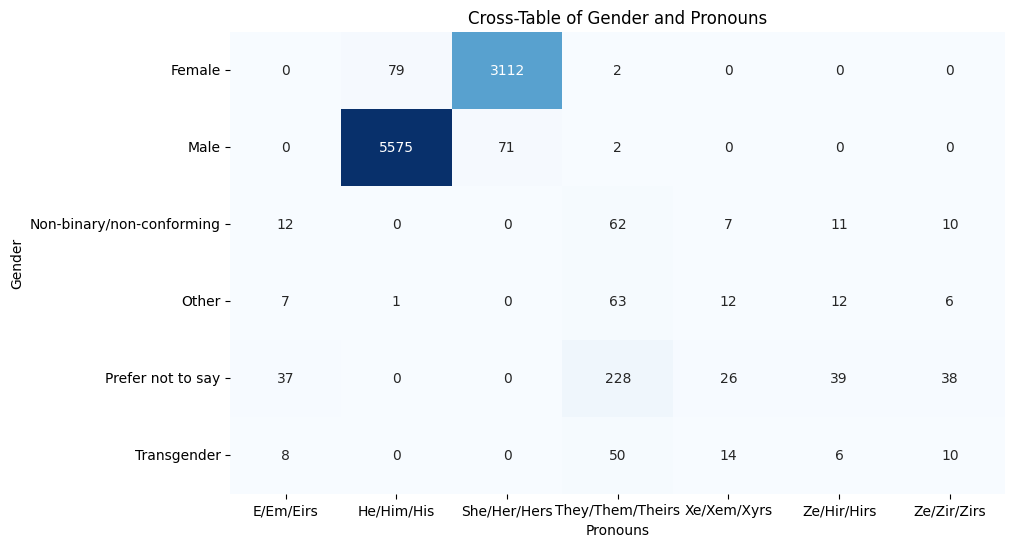

In [38]:
cross_table = pd.crosstab(dataset['Gender'], dataset['Pronouns'])

plt.figure(figsize=(10, 6))
sns.heatmap(cross_table, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Cross-Table of Gender and Pronouns')
plt.xlabel('Pronouns')
plt.ylabel('Gender')
plt.show()

From the matrix it is obvious that the columns Gender and Pronouns are highly correlated. Since Pronouns often reflect the gender identity of an individual, it may be sufficient to retain only one of them for my task. 

In [40]:
dataset_new = dataset_cleaned.drop("Pronouns", axis=1)

In this section, we will examine the correlation between numerical features and the target variable, Manager, using a Pearson correlation heatmap.

The Pearson correlation measures the linear relationship between two variables, with values ranging from -1 to +1. A value of +1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation. This metric is particularly useful for understanding the strength and direction of the relationship between the numerical features in the dataset and the target variable.

By creating a heatmap of the Pearson correlation matrix, we can easily identify which features are most strongly correlated with the Manager column. For the purpose of this correlation calculation, 'Yes' will be mapped to 1 and 'No' to 0. This approach enables us to ascertain which numerical features influence the target variable.

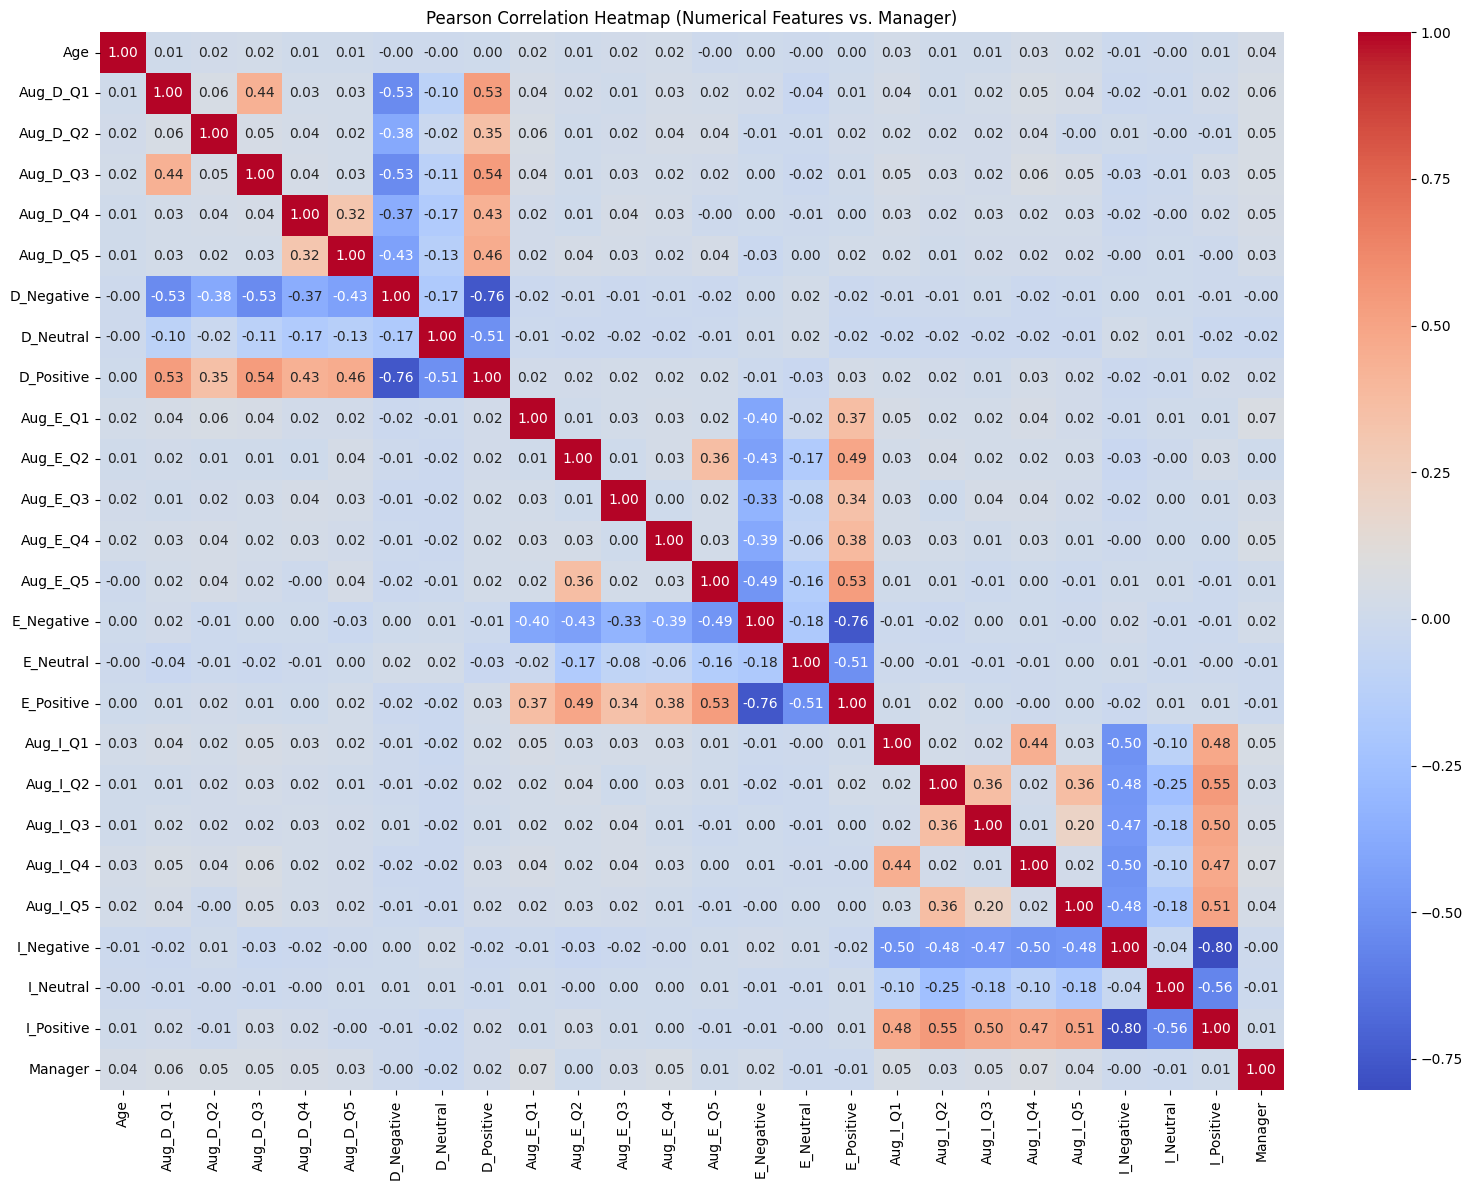

In [18]:
# For numerical columns only (including the 'Manager' column)
numerical_columns = dataset_new.select_dtypes(include=['float64', 'int64']).columns

# We want to compute Pearson correlation for numerical columns only, including the target 'Manager'
# But 'Manager' is categorical, so we will first map it to 0 and 1 for now, only for the correlation calculation
dataset_new['Manager'] = dataset_new['Manager'].map({'Yes': 1, 'No': 0})

# Compute the Pearson correlation matrix for the numerical columns
correlation_matrix = dataset_new[numerical_columns.to_list() + ['Manager']].corr(method='pearson')

# Increase the figure size for better readability
plt.figure(figsize=(16, 12))  # You can increase this even more if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Pearson Correlation Heatmap (Numerical Features vs. Manager)')
plt.tight_layout()
plt.show()

The correlation values are very low, close to 0, suggesting that none of the numerical features have a meaningful linear relationship with the target variable Manager. This might mean that either:

- the relationship is not linear, since Pearson capture linear relationship only.

- the features do not contribute significantly to managerial status.

One possible option is using non-linear techniques to capture non-potential linear relationships.

For categorical features, we'll analyze the correlation between each category and the Manager column. Even though Pearson's correlation is usually for numerical data, we can apply it to categorical data by looking at the frequency of each category. This shows us how often different categories in each feature relate to the target variable.

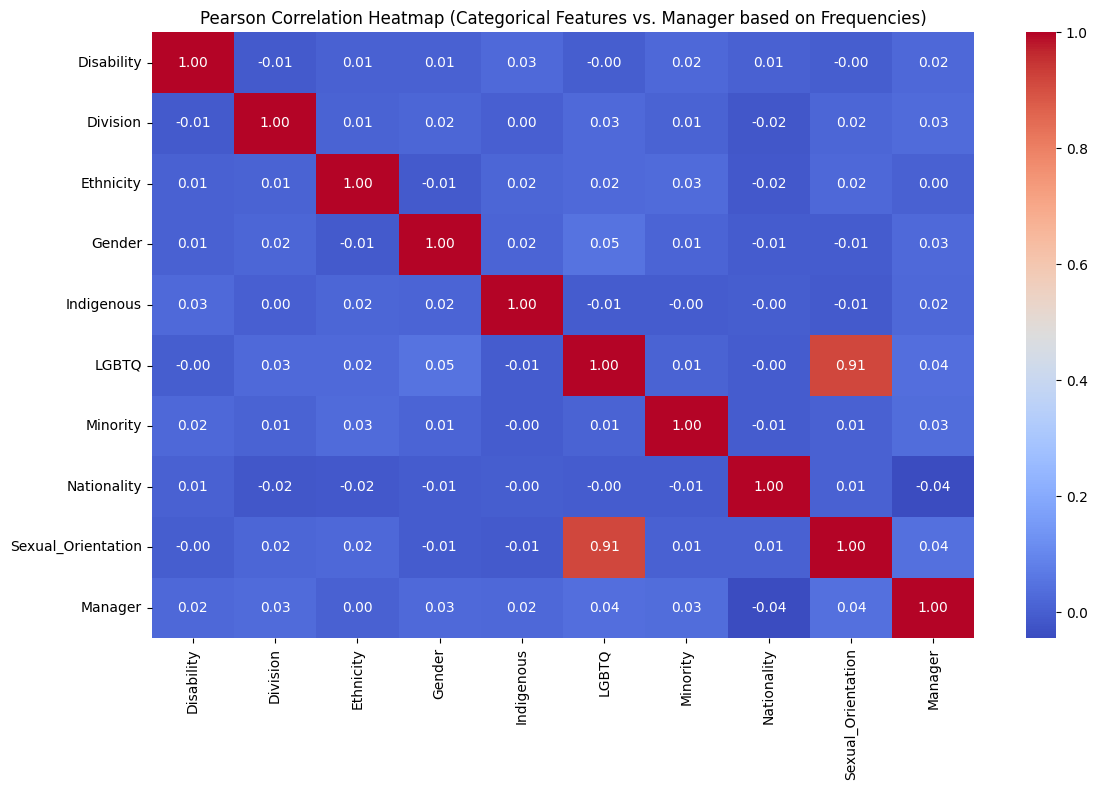

In [19]:
# For categorical columns (excluding 'Manager' as it's already included)
categorical_columns = dataset_new.select_dtypes(include=['object']).columns.difference(['Manager'])

# Create a frequency-based transformation function
def get_category_frequencies(dataset_new, categorical_columns):
    # This will create a frequency map for each categorical column
    for col in categorical_columns:
        freq = dataset_new[col].value_counts(normalize=True)  # Normalize to get frequency as a percentage
        dataset_new[col] = dataset_new[col].map(freq)  # Replace categories with their frequency
    return dataset_new

# Apply the function to map categorical values to their frequencies
dataset_with_frequencies = get_category_frequencies(dataset_new.copy(), categorical_columns)

# Compute the Pearson correlation matrix for the categorical features with frequencies
correlation_matrix_cat = dataset_with_frequencies[categorical_columns.to_list() + ['Manager']].corr(method='pearson')

# Plot the heatmap for categorical features with frequencies
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_cat, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Pearson Correlation Heatmap (Categorical Features vs. Manager based on Frequencies)')
plt.tight_layout()
plt.show()

Analyzing the data, the correlation with other characteristics is low for categorical data as well. The stronger association among categorical variables is with LGBTQ and Sexual_Orientation, suggesting a weak but slightly stronger association compared to other categorical features. 

Although an effective predictive model may not be achievable with the current data, conducting further exploratory analysis could still provide valuable insights. This approach can help identify any latent patterns or trends within the dataset that may not be immediately apparent. By focusing on uncovering these underlying relationships, we can gain a deeper understanding of the factors influencing the data, which could inform more targeted and ethical decision-making in future model development.

Before applying any computations, transformations, or designing the pipeline, it is essential to remove the target column from the feature set. This is done to ensure that the target column ("Manager") is not inadvertently included in the preprocessing or transformation steps applied to the features.  Including the target variable in the transformations could lead to data leakage, where information from the target might influence the transformations of the input features.

 Therefore, to maintain the integrity of the model and avoid biases, the target column is excluded from the feature engineering and preprocessing stages, and is only used during model training.

In [20]:
X = dataset_new.drop(columns=['Manager'])  # Remove the target column
y = dataset_new['Manager']  # Extract the target column

To have a complete overview of the most important features and the required transformation, I draw this sketch. In this way, I know the pipeline, the sequence of transformation, required for each column. 

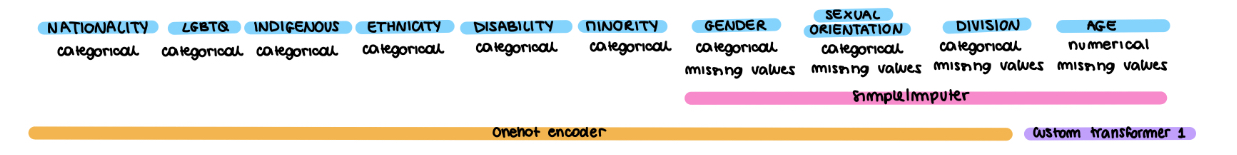

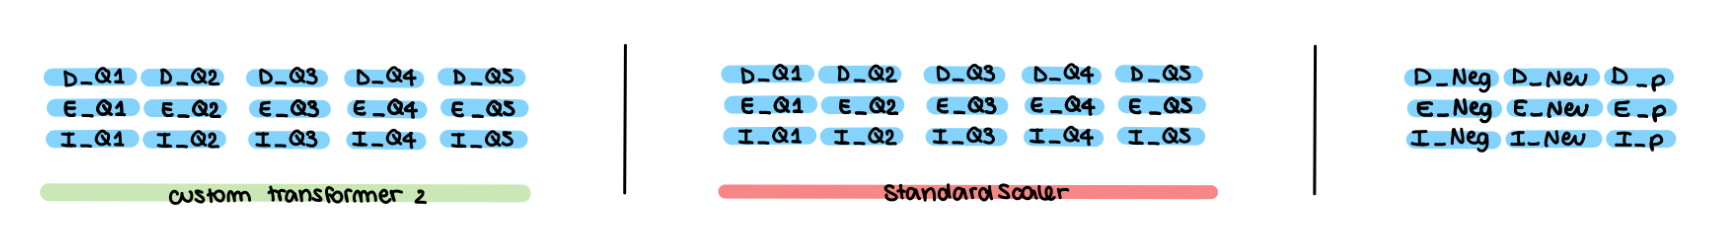

For the Age column:

- Simple Imputer: Handles missing data by replacing missing values with a statistic, in this case the mean.

- FunctionTransformer:  Apply a custom function as part of a data transformation pipeline.

For the Division, Gender, Sexual_orientation columns:

- Simple Imputer: Handles missing data by replacing missing values with a statistic. As a strategy, I use 'most_frequent' since the features are categorical.

- OneHot Encoder: Encode categorical data which do not have an inherent order. This involves creating a new binary column (dummy variable) for each unique category. 

For the other categoricals columns we use OneHot Encoder.

Let's now focus on the Aug_* columns.

The primary objective of my project is to identify which features most significantly influence the determination of an individual's managerial position. To investigate this, I intend to analyze whether summarizing the diversity, equity, and inclusion (DEI) related columns—by calculating their mean and standard deviation—affects the model's performance or leads to the omission of critical information.

To this end, I will create two pipelines to apply to the dataset: one that summarize DEI features (mean and standard deviation) with the custom transformer Summarizer, and another that only apply the Standard Scaler transformation. This methodology will facilitate a comparative analysis to evaluate whether the summarization impacts the model's efficacy in accurately identifying the key predictive features.

First, I start to define the pipeline where I standardize the DEI features related columns. The StandardScaler standardizes features by removing the mean and scaling them to unit variance, resulting in a distribution with a mean of 0 and a standard deviation of 1. Moreover, I put remainder='passthrough' that specifies how columns that are not explicitly mentioned in the transformer should be handled. In this case, it means that these columns will be left untouched and included in the output alongside the transformed columns. 

In [21]:
groups = {
    'D': ['Aug_D_Q1', 'Aug_D_Q2', 'Aug_D_Q3', 'Aug_D_Q4', 'Aug_D_Q5'],
    'E': ['Aug_E_Q1', 'Aug_E_Q2', 'Aug_E_Q3', 'Aug_E_Q4', 'Aug_E_Q5'],
    'I': ['Aug_I_Q1', 'Aug_I_Q2', 'Aug_I_Q3', 'Aug_I_Q4', 'Aug_I_Q5']
}

# Define age bins and numeric labels
age_bins = [20, 30, 40, 50, 60, float('inf')]  # Define the edges of your bins
age_labels = [0, 1, 2, 3, 4]  # Labels for each bin

# Function to bin ages into numeric categories
def bin_ages_to_numbers(X):
    # Apply pd.cut to bin ages into categories
    binned_ages = pd.cut(X[:, 0], bins=age_bins, labels=age_labels, right=False)
    return binned_ages.astype(int).reshape(-1, 1)

# Update the FunctionTransformer for numerical binning
age_binner_numeric = FunctionTransformer(bin_ages_to_numbers, validate=True, feature_names_out="one-to-one")

# Update the Age pipeline to use numeric binning
pipeline_age_numeric = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('binner', age_binner_numeric)               # Apply numeric age binning
])

# Pipeline for Division column: Use SimpleImputer and then OneHotEncoder
pipeline_DGS = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values with the most frequent value
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # OneHotEncode the categorical values
])

# Pipeline for other categorical columns: Nationality, LGBTQ, Indigenous, Ethnicity, Disability, Minority
pipeline_categorical_simple = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # OneHotEncode directly
])

# Pipeline for the StandardScaler of the D, E, I groups
pipeline_scaler = Pipeline([
    ('scaler', StandardScaler())  # Applica StandardScaler
])

# Final ColumnTransformer
final_transformation = ColumnTransformer(transformers=[
    ('age', pipeline_age_numeric, ['Age']),  # Apply the pipeline to the Age column
    ('DGS', pipeline_DGS, ['Division', 'Gender', 'Sexual_Orientation']),  # Apply SimpleImputer and OneHot to these columns
    ('categorical_simple', pipeline_categorical_simple, ['Nationality', 'LGBTQ', 'Indigenous', 'Ethnicity', 'Disability', 'Minority']),  # Apply OneHot to other categorical columns
    ('scaler_D', pipeline_scaler, groups['D']),  # StandardScaler per il gruppo D
    ('scaler_E', pipeline_scaler, groups['E']),  # StandardScaler per il gruppo E
    ('scaler_I', pipeline_scaler, groups['I'])   # StandardScaler per il gruppo I
],

remainder='passthrough',  # Ensure all other columns are retained in the final output
verbose_feature_names_out=False,  # Clean output feature names
sparse_threshold=0  # Always return dense matrices
)

In the age columns, bin_age_to_numbers firstly divide the value in age_bins, that defines the age ranges that I want to create: the ages are grouped into bins like: 20-29, 30-39, 40-49, 50-59, 60 and older (using float('inf') for the upper bound).

Then the age_labels assigns a numeric label to each age group (bin): 

0 for ages 20-29
1 for ages 30-39
2 for ages 40-49
3 for ages 50-59
4 for ages 60 and above

Now, I define the pipeline to summarize the DEI features related columns. 

My custom summarized transformer processes predefined group of columns (the Diversity (D), Equity (E) and Inclusion (I) scores columns) by calculating the mean and the standard deviation. This transformer works by:

- Iterating through the groups of columns, computing the summary statistics (mean and standard deviation) for each group.

- Replacing the original columns with the new summarized features (*_Mean and *_Std).

It implements the get_feature_names_out method to ensure the pipeline outputs meaningful feature names, reflecting the new summarized columns.

In [22]:
# Implement the get_feature_names_out method in the custom Summarizer transformer
class Summarizer(BaseEstimator, TransformerMixin):
    def __init__(self, groups):
        self.groups = groups

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for prefix, columns in self.groups.items():
            # Calculate mean and standard deviation
            X[f'{prefix}_Mean'] = X[columns].mean(axis=1)
            X[f'{prefix}_Std'] = X[columns].std(axis=1)
            # Drop original columns
            X = X.drop(columns=columns)
        return X

    def get_feature_names_out(self, input_features=None):
        feature_names = []
        for prefix in self.groups.keys():
            feature_names.append(f'{prefix}_Mean')
            feature_names.append(f'{prefix}_Std')
        return feature_names

# Groups for summarization
groups = {
    'D': ['Aug_D_Q1', 'Aug_D_Q2', 'Aug_D_Q3', 'Aug_D_Q4', 'Aug_D_Q5'],
    'E': ['Aug_E_Q1', 'Aug_E_Q2', 'Aug_E_Q3', 'Aug_E_Q4', 'Aug_E_Q5'],
    'I': ['Aug_I_Q1', 'Aug_I_Q2', 'Aug_I_Q3', 'Aug_I_Q4', 'Aug_I_Q5']
}

# Pipeline for summarizing Aug_* columns
summarization_pipeline = Pipeline([
    ('summarizer', Summarizer(groups=groups))  # Custom summarizer
])

# Define age bins and numeric labels
age_bins = [20, 30, 40, 50, 60, float('inf')]  # Define the edges of your bins
age_labels = [0, 1, 2, 3, 4]  # Labels for each bin

# Function to bin ages into numeric categories
def bin_ages_to_numbers(X):
    # Apply pd.cut to bin ages into categories
    binned_ages = pd.cut(X[:, 0], bins=age_bins, labels=age_labels, right=False)
    return binned_ages.astype(int).reshape(-1, 1)

# Update the FunctionTransformer for numerical binning
class CustomFunctionTransformer(FunctionTransformer):
    def get_feature_names_out(self, input_features=None):
        return input_features

# Use the CustomFunctionTransformer instead of the default
age_binner_numeric = CustomFunctionTransformer(func=bin_ages_to_numbers, validate=True)

# Update the Age pipeline to use numeric binning
pipeline_age_numeric = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('binner', age_binner_numeric)               # Apply numeric age binning
])

# Pipeline for Division, Gender, and Sexual_Orientation columns
pipeline_DGS = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values with the most frequent value
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # OneHotEncode the categorical values
])

# Pipeline for other categorical columns
pipeline_categorical_simple = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # OneHotEncode directly
])

# Combine everything into a final ColumnTransformer
final_transformation_summarization = ColumnTransformer(transformers=[
    ('age', pipeline_age_numeric, ['Age']),  # Age column pipeline
    ('DGS', pipeline_DGS, ['Division', 'Gender', 'Sexual_Orientation']),  # Division, Gender, Sexual_Orientation pipeline
    ('categorical_simple', pipeline_categorical_simple, ['Nationality', 'LGBTQ', 'Indigenous', 'Ethnicity', 'Disability', 'Minority']),  # Other categorical columns
    ('summarization', summarization_pipeline, list(groups['D'] + groups['E'] + groups['I'])),  # Summarization pipeline
],
remainder='passthrough',  # Ensure all other columns are retained
verbose_feature_names_out=False,  # Clean output feature names
sparse_threshold=0  
)

These are the new columns created with the customize transformer.

These are the new datasets processed in order to transform them into a suitable format for model training. Below there are the comparison between the two datasets processed.

## Model Selection

Now, I can divide the datasets into training and test sets. The split will allocate 80% of the dataset for training and 20% for testing, as the dataset is relatively large. The split was stratified (stratify=y) to ensure that the class distribution in both the training and test sets was representative of the original distribution in the dataset.

The training data (X_train) was transformed using the final_transformation (or final_transformation_summarization) transformer, previously defined in the code. The fit_transform method was employed to fit and then transform the training data.

The test data (X_test) was transformed using the same final_transformation (or final_transformation_summarization) transformer. In this instance, the transform method was used, applying the transformation learned during the training data fitting, without re-fitting it to the test data. 

The transformed data was converted into DataFrames using the pandas library to facilitate subsequent operations and enhance readability. The DataFrames were created using the transformed data (X_train_transformed and X_test_transformed or X_train_summarization_transformed and X_test_summarization_transformed), with column names extracted from the transformer via the get_feature_names_out() method.

In [23]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=30, shuffle=True)

In [24]:
# Fit and transform on the training data
X_train_transformed = final_transformation.fit_transform(X_train)

# Transform the test data using the fitted transformer
X_test_transformed = final_transformation.transform(X_test)

# Convert to DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns=final_transformation.get_feature_names_out())
X_test_df = pd.DataFrame(X_test_transformed, columns=final_transformation.get_feature_names_out())

In [25]:
# Fit and transform on the training data
X_train_summarization_transformed = final_transformation_summarization.fit_transform(X_train)

# Transform the test data using the fitted transformer
X_test_summarization_transformed = final_transformation_summarization.transform(X_test)

# Convert to DataFrame
X_train_summarization_df = pd.DataFrame(X_train_summarization_transformed, columns=final_transformation_summarization.get_feature_names_out())
X_test_summarization_df = pd.DataFrame(X_test_summarization_transformed, columns=final_transformation_summarization.get_feature_names_out())

We now define the pipeline for the model, which includes:

- SMOTE to address unbalanced classes.

- PCA to reduce the dimensionality of the data while retaining 90% of the variance, ensuring the preservation of most useful information by reducing the number of principal components.

- Random Forest as the classifier.

Utilizing a pipeline ensures that all steps are executed sequentially, minimizing the risk of manual errors in data management.

In [26]:
model_pipeline = IMBPipeline([
    ('sampler', SMOTE(random_state=42)),  # Handling unbalanced classes
    ('dim_reduction', PCA(n_components=0.90)),  # Dimensionality reduction, retains 90% of variance
    ('classifier', RandomForestClassifier(random_state=42))  # Selected classifier
])

In [27]:
model_pipeline_summarization = IMBPipeline([
    ('sampler', SMOTE(random_state=42)),  # Handling unbalanced classes
    ('dim_reduction', PCA(n_components=0.90)),  # Dimensionality reduction, retains 90% of variance
    ('classifier', RandomForestClassifier(random_state=42))  # Selected classifier
])

I will now verify that all components are well-defined and functioning properly to ensure that the model can be trained and make  predictions correctly.

In [28]:
model_pipeline.fit(X_train_transformed,y_train)

Pipeline(steps=[('sampler', SMOTE(random_state=42)),
                ('dim_reduction', PCA(n_components=0.9)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [29]:
model_pipeline_summarization.fit(X_train_summarization_transformed,y_train)

Pipeline(steps=[('sampler', SMOTE(random_state=42)),
                ('dim_reduction', PCA(n_components=0.9)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [30]:
predictions = model_pipeline.predict(X_test_transformed)
predictions

array([0, 0, 1, ..., 0, 0, 0])

In [31]:
predictions_summarized = model_pipeline_summarization.predict(X_test_summarization_transformed)
predictions_summarized

array([0, 0, 0, ..., 0, 0, 0])

All the informations seems correctly defined, it is time to define the configurations of the hyperparameter I use in the hyperparameter optimization phase of the model selection. 

Therefore, we define each possible configurations for each step in the pipeline: sampler, dimensionality reduction and classifier. Each configuration is represented as a dictionary, where for the key there is the pipeline step name and for the value the step-specific object or instance and in general mixed values. 

In [32]:
# Sample configurations
sampler_configs = [
    {
        'sampler': [None],  
    },
    {
        'sampler': [SMOTE(n_jobs=-1, random_state=42)],
        'sampler__sampling_strategy': ['minority', 1.0, 0.8, 0.6]
    },
    {
        'sampler': [RandomOverSampler(random_state=42)],
        'sampler__sampling_strategy': [0.5, 0.7, 'not minority']
    }
]

# Dimensionality reduction configurations
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA(random_state=42)],
        'dim_reduction__n_components': [0.9, 0.95, 15, 20]
    },
    {
        'dim_reduction': [LDA()],
        'dim_reduction__n_components': [1, 2]
    },
    {
        'dim_reduction': [SFS(estimator=LogisticRegression(max_iter=1000), cv=None, scoring='f1')],
        'dim_reduction__estimator': [LogisticRegression(max_iter=1000), DecisionTreeClassifier()],
        'dim_reduction__k_features': [5, 10, 15]
    }
]

# Classifier configurations
classifier_configs = [
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C': loguniform(0.001, 10),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],  
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2, 3]
    },
    {
        'classifier': [XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [50, 100, 150],  
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 6, 9],
        'classifier__subsample': [0.8, 1.0],
    },
]


Let's comment each choice.

Sampler Configuration:

- None:  serves as a baseline to evaluate the model's performance without any resampling. It helps quantify the effect of samplers by comparison.

- SMOTE:  generates synthetic samples for the minority class, which helps address class imbalance. By including various sampling strategies, it tests different levels of oversampling to find the optimal balance for the dataset.

- RandomOverSampler: increases the number of samples from the minority class by creating duplicates or synthetic samples, helping to balance the dataset and improve the model's ability to learn patterns from underrepresented classes. The flexibility in sampling strategies allows it to address various levels of class imbalance effectively.

Dimensionality Reduction Configurations

- PCA: reduces the dataset's dimensionality by retaining the most important components that explain a specified proportion of variance. It's computationally efficient and effective for high-dimensional continuous features.

- LDA: projects the data onto a lower-dimensional space that maximizes class separability, making it particularly useful for classification tasks with well-separated classes.

- SFS: incrementally selects the most important features using a specified estimator (LogisticRegression, DecisionTreeClassifier) and evaluates subsets based on f1 scoring. This approach is effective for identifying the most predictive features, especially when feature importance is unclear.

Classifier Configurations

- Logistic Regression: a robust baseline model for classification tasks. The inclusion of hyperparameters such as regularization strength (C), penalty types (l1, l2), and class weights (None, balanced) allows for optimization to effectively handle both overfitting and class imbalance.

- Random Forest: a versatile ensemble method that aggregates predictions from multiple decision trees to improve accuracy and reduce overfitting. Tuning the number of estimators (10, 50, 100) provides control over the trade-off between computational cost and model performance.

- XGBoosting: a powerful ensemble learning method that builds models sequentially to minimize errors by optimizing a differentiable loss function. The inclusion of hyperparameters such as learning rate, number of estimators, and maximum tree depth allows for fine-tuning to balance model complexity and performance, making it highly effective for both regression and classification tasks.

Then, I generate all the possible combinations of configurations using intertools.product, that performs the Cartesian product between all the values provided. Therefore, it takes one element from each input iterable and the result is a tuple that includes one element from each list

In [35]:
all_configs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

The inner loop implement the merging of the dictionary and the output is a list (all_parameters) of pairs transformed into a dictionary. Therefore, at the end, all_configs is a list of dictionaries where each dictionary is a parameter of the pipeline. 

Now we have 48 configurations:

In [36]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 36'

For example, these are the first two dictionaries of the list:

In [37]:
all_configs[:2]

[{'sampler': [None],
  'dim_reduction': [None],
  'classifier': [LogisticRegression(solver='saga')],
  'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f1dec3bb280>,
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None, 'balanced']},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [RandomForestClassifier()],
  'classifier__n_estimators': [50, 100, 200],
  'classifier__max_depth': [None, 10, 20],
  'classifier__min_samples_split': [2, 5],
  'classifier__min_samples_leaf': [1, 2, 3]}]

Once I have defined all the possible configurations, the first step is to pick one of the configuration randomly and use all the information within the selected configuration to generate the hyperparameters. I am implementing a nested picking process.

As a result, I can implement the nested cross validation that comprises of:

- The inner loop: the Randomize Grid Search, in which we optimize the hyperparameters. Instead of exhaustively testing all combinations of hyperparameters like in GridSearchCV, I randomly pick combinations based on predefined probability distributions for each hyperparameter. This allows me to efficiently search through large hyperparameter spaces. 

- The outer loop: the k-fold-cross-validation, which evaluate the performance of the models. For each fold (the iteration), we define the classifier, the estimator (which is the placeholder of the pipeline) and the different distributions distributions from which to generate the hyperparameter values (I need to pass all the configurations). 

We start with the inner loop.

To ensure consistency and fairness in evaluating the models, I define a cross-validation strategy (cv_strategy). This strategy, based on StratifiedKFold, splits the data into k folds, ensuring that each fold preserves the proportion of the target classes. This is crucial for imbalanced datasets, as it prevents folds from being dominated by one class.

In [34]:
# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV for hyperparameter tuning
rs = RandomizedSearchCV(
    model_pipeline,  # The model pipeline (with SMOTE, PCA, or other steps)
    param_distributions=all_configs,  # Hyperparameter configurations to explore
    n_iter=50,  # Number of random combinations to test
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    cv=cv_strategy,  # Use the defined cross-validation strategy
    scoring='f1',  # Use F1 score as the evaluation metric
    verbose=1,  # Show progress during execution
    random_state=42  # For reproducible results
)

The RandomizedSearchCV object is instantiated with the model_pipeline and the dictionary of hyperparameter configurations (all_configs). The parameter n_iter is set to five times the total number of configurations to test many random combinations of hyperparameters. 

Setting n_jobs=-1 enables parallel execution across all available CPU cores, and cv=2 specifies two-fold cross-validation for the inner loop of nested cross-validation. The scoring='f1' argument indicates that the F1 score, a balance between precision and recall, is the metric used to evaluate model performance during hyperparameter optimization.

For what concern the outer loop, the cross_validate function is used to evaluate the RandomizedSearchCV object (rs) on the transformed training data (X_train_transformed) and labels (y_train) using three-fold cross-validation. The evaluation is based on the F1 score (scoring='f1'). By setting return_estimator=True, the function returns the fitted models from each fold. The verbose=3 argument increases logging output for better traceability, while n_jobs=-1 enables parallelization. The pre_dispatch='2*n_jobs' setting optimizes memory usage when processing large datasets by limiting the number of jobs dispatched simultaneously. 

Since I use cross_validate to implement the outer loop, it return a dictionary providing all the details about the cross validation. So, it means that for each iteration in the cross validation, the best model is selected.

In [35]:
# Perform cross-validation on the specified model (rs - RandomizedSearchCV)
scores = cross_validate(
    rs,  # The model to evaluate, in this case, RandomizedSearchCV
    X_train_transformed,  # The transformed training data
    y_train,  # The corresponding target labels
    scoring='f1',  # The evaluation metric to use, in this case, the F1 score
    cv=cv_strategy,  # Use the same cross-validation strategy
    return_estimator=True,  # Returns the trained estimators for each fold for further analysis
    verbose=3,  # Displays detailed progress during execution
    n_jobs=-1,  # Utilizes all available CPU cores to parallelize computations
    pre_dispatch='2*n_jobs'  # Controls memory usage by pre-dispatching jobs to available workers
)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ......................................, score=0.441 total time=101.4min
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ......................................, score=0.442 total time=103.7min
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ......................................, score=0.436 total time=110.0min


The F1 scores across different folds (~0.44) suggest that the model faces challenges in reliably predicting the managerial status of employees using this transformation pipeline. However, the scores are not indicative of complete failure, hinting that some patterns exist within the data. These patterns could potentially arise from:

- Systematic biases in managerial selection processes.

- Correlations between specific demographic features and managerial positions.

The low F1 score also suggest that these biases, while present, are not overwhelmingly strong. 

In [36]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE(n_jobs=-1, random_state=42, sampling_strategy=1.0)
SequentialFeatureSelector(cv=None, estimator=DecisionTreeClassifier(),
                          k_features=(10, 10), scoring='f1')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...) {'objective': 'binary:logistic', 'base_score': None, 'bo

This code identifies the best configurations for samplers, dimensionality reduction, and classifiers based on the cross-validation results. The scores allow us to determine which techniques perform best in this specific context:

- Best Sampler: SMOTE with a sampling strategy of 1.0 performed optimally, addressing the class imbalance effectively. This ensures that underrepresented groups are sufficiently represented in the training data.

- Best Dimensionality Reduction: SequentialFeatureSelector (using a DecisionTreeClassifier) outperformed PCA and LDA. This emphasizes the importance of selecting relevant features over reducing dimensionality based purely on variance or linear discriminants.

- Best Classifier: XGBClassifier with tuned hyperparameters (learning_rate=0.2, max_depth=6, n_estimators=50) yielded the best results. This underscores the effectiveness of boosting methods in uncovering complex, nonlinear relationships in the dataset.

In [37]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train_transformed, y_train)
    pred_train = estimator.best_estimator_.predict(X_train_transformed)
    pred_test = estimator.best_estimator_.predict(X_test_transformed)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.44433526579542104, F1 on test set:0.4400785854616896
F1 on training set:0.44433526579542104, F1 on test set:0.4400785854616896
F1 on training set:0.44433526579542104, F1 on test set:0.4400785854616896


The F1 scores for the training (~0.444) and test (~0.440) sets are closely aligned, indicating minimal overfitting. However, the low scores across both sets highlight potential underfitting, suggesting that the pipeline might not capture sufficient complexity or nuanced patterns in the dataset. This raises concerns about the pipeline’s ability to identify structural biases or hidden inequities in managerial inclusivity.

Now, I do the same for X_train_transformed_summarization:

In [35]:
# Cross-validation to evaluate the model
scores_summarization = cross_validate(
    rs,  # Pass RandomizedSearchCV as the model to evaluate
    X_train_summarization_transformed,  # Transformed training data
    y_train,  # Training labels
    scoring='f1',  # Use F1 score as the evaluation metric
    cv=cv_strategy,  # Use the same cross-validation strategy
    return_estimator=True,  # Return trained estimators for further analysis
    verbose=3,  # Display more details during execution
    n_jobs=-1,  # Parallelize the computation
    pre_dispatch='2*n_jobs'  # Manage memory allocation for parallel jobs
)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ......................................, score=0.397 total time=119.0min
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ......................................, score=0.443 total time=102.0min
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ......................................, score=0.371 total time=111.9min


In [36]:
# Fixed code to use the correct variable 'scores_summarization' instead of 'scores'
for index, estimator in enumerate(scores_summarization['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'], estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores_summarization['test_score'][index])  # Corrected the variable name
    print('-'*10)

RandomOverSampler(random_state=42, sampling_strategy=0.5)
None
LogisticRegression(C=0.01329652145729951, class_weight='balanced', penalty='l1',
                   solver='saga') {'C': 0.01329652145729951, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.3965702036441586
----------
SMOTE(n_jobs=-1, random_state=42, sampling_strategy=1.0)
SequentialFeatureSelector(cv=None, estimator=DecisionTreeClassifier(),
                          k_features=(10, 10), scoring='f1')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, ga

Best sampler, dimensionality reduction and classifier (the same result as before):

- SMOTE effectively addresses class imbalance.

- SequentialFeatureSelector with DecisionTreeClassifier identifies impactful features better than PCA or LDA.

- XGBClassifier performs strongly, leveraging nonlinear feature interactions.

In [37]:
for estimator in scores_summarization['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train_summarization_transformed, y_train)
    pred_train = estimator.best_estimator_.predict(X_train_summarization_transformed)
    pred_test = estimator.best_estimator_.predict(X_test_summarization_transformed)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.382863759166345, F1 on test set:0.3711824588880188
F1 on training set:0.44433526579542104, F1 on test set:0.4400785854616896
F1 on training set:0.3979018358935931, F1 on test set:0.3684210526315789


The results indicate that the F1-score on the training set ranges between ~0.38 and ~0.44, while the test set F1-score varies between ~0.36 and ~0.44. The overall performance remains suboptimal, with no consistent improvement on the test set, indicating that the extensive summarization may have led to a loss of relevant information, thus limiting the model's ability to generalize effectively.

In contrast, the results from X_train_transformed show consistent F1-scores for both the training (~0.444) and test (~0.440) sets. This stability highlights that the less summarized dataset retains sufficient information for the model to perform comparably on both sets. Additionally, the lack of variability in the performance metrics indicates that the simpler preprocessing pipeline preserves critical patterns in the data, supporting better generalization.

Based on these observations, the additional summarization in X_train_transformed_summarization does not provide significant benefits and may even reduce the model's predictive capacity. Therefore, X_train_transformed has been selected for model refinement to ensure that the dataset retains its original richness, enabling the model to achieve more consistent and reliable performance.

## Refinement of the selected model

In the previous part, we have selected one of the best candidate models. Now, we re-run the hyperparameter optimization fixing the modelling approach and varying the hyperparameters in a range close to selected model's one.

In [37]:
# Best sampler 
sampler = SMOTE(n_jobs=-1, random_state=42, sampling_strategy=1.0)  

# Best dimensionality reduction
feature_selector = SFS(
    estimator=DecisionTreeClassifier(random_state=42),  # Decision tree as the base model
    k_features=10,  # Best selection of features
    scoring="f1",
    cv=None,
)

# Best classifier
classifier = XGBClassifier(
    random_state=42,
    learning_rate=0.2,  # Best learning rate
    max_depth=6,        # Best max depth
    n_estimators=50,   # Best number of estimators
    subsample=1.0,      # Best subsample
    eval_metric="logloss",
    use_label_encoder=False,
)

# The best model pipeline
best_model_pipeline = IMBPipeline([
    ("sampler", sampler),
    ("feature_selection", feature_selector),
    ("classifier", classifier),
])

Now, I define the hyperparameter search space for the classifier in the pipeline. It specifies ranges and values for the XGBClassifier's key parameters: learning rate (step size for gradient descent), max depth (tree complexity), and number of estimators (boosting rounds). These parameters are optimized using RandomizedSearchCV to identify the configuration that maximizes model performance.

In [38]:
# Best hyperparameters for hyperparameter tuning
params = {
    "classifier__learning_rate": uniform(0.1, 0.2), 
    "classifier__max_depth": [3, 6, 9],
    "classifier__n_estimators": [25, 50, 75, 100],
}

In this section, I set up and executed the hyperparameter optimization process for the pipeline using RandomizedSearchCV. The search evaluates 20 random configurations of the pipeline's hyperparameters, leveraging repeated stratified k-fold cross-validation (5 splits, 3 repeats) to ensure robust evaluation. The optimization aims to identify the best combination of parameters that maximizes the F1 score, which is the chosen metric to address class imbalance effectively.

In [39]:
rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,
    param_distributions=params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
    n_iter=20,
    scoring="f1",
    random_state=42,
    n_jobs=-1,
    error_score="raise",  # Raise errors for debugging
)

After defining the search, I fit RandomizedSearchCV to the transformed training data. This step applies the entire pipeline—oversampling, feature selection, and classification—while systematically evaluating the defined hyperparameter configurations.

In [41]:
# Fit the pipeline to the training data
rs_best.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
                   error_score='raise',
                   estimator=Pipeline(steps=[('sampler',
                                              SMOTE(n_jobs=-1, random_state=42,
                                                    sampling_strategy=1.0)),
                                             ('feature_selection',
                                              SequentialFeatureSelector(cv=None,
                                                                        estimator=DecisionTreeClassifier(random_state=42),
                                                                        k_features=10,
                                                                        scoring='f1')),
                                             ('classifier',
                                              XGB...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=50,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f563523e040>,
                                        'classifier__max_depth': [3, 6, 9],
                                        'classifier__n_estimators': [25, 50, 75,
                                                                     100]},
                   random_state=42, scoring='f1')

Subsequently, I extract the best model from RandomizedSearchCV and evaluated its performance on the test set by calculating the F1 score. The best hyperparameter configuration and the corresponding test set performance were printed for analysis, providing insight into the effectiveness of the refined pipeline.

In [42]:
# Evaluate the model on the test set
best_model = rs_best.best_estimator_
f1_test = f1_score(y_test, best_model.predict(X_test_transformed))
print("Best Model Configuration:", rs_best.best_params_)
print("F1 Score on Test Set:", f1_test)

Best Model Configuration: {'classifier__learning_rate': 0.14617876512442982, 'classifier__max_depth': 9, 'classifier__n_estimators': 100}
F1 Score on Test Set: 0.4161616161616162


In this section, I use a learning curve to evaluate the model's performance and visualize how it changes with varying training set sizes. The learning curve provides insights into the model's learning behavior, helping to diagnose issues like underfitting or overfitting.

The learning_curve function calculates training and validation scores for different proportions of the training set, using 5-fold cross-validation and the F1 score as the evaluation metric. The mean and standard deviation of the scores are computed to summarize the model's performance across folds.

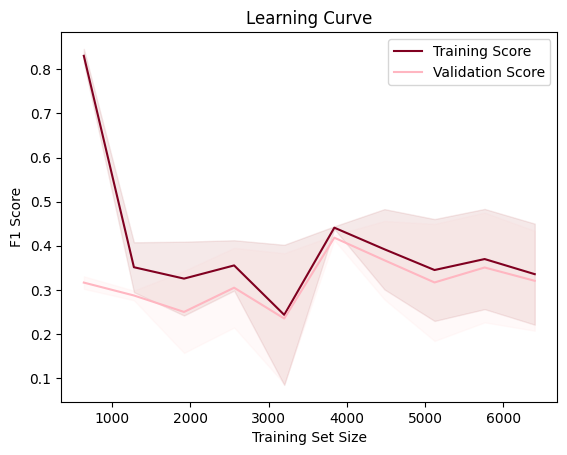

In [43]:
# Plot the learning curve to visualize performance
train_sizes, train_scores, test_scores = learning_curve(
    best_model_pipeline,
    X_train_transformed,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label='Training Score', color="#800020")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="#A52A2A")
plt.plot(train_sizes, test_mean, label='Validation Score', color="#FFB6C1")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="#FFCCCB")
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

The learning curve highlights the F1 score evolution for the training and validation datasets as the training set size increases. Initially, the training score is very high, indicative of overfitting on smaller datasets. As the training size grows, the training score declines and stabilizes around 0.41, indicating that the model generalizes better but still fails to capture complex patterns in the data. The validation score starts significantly lower but improves with more training data, eventually converging near the training score.

The final F1 score on the full dataset is 0.41, which is slightly lower than the cross-validation F1 score (mean of 0.440). This discrepancy could result from variability in the cross-validation splits, potentially providing more favorable conditions for learning the data structure. Overall, the model struggles with generalization, likely due to dataset complexity or limitations in feature expressiveness.

The precision-recall curve demonstrates the trade-off between precision and recall at various classification thresholds.

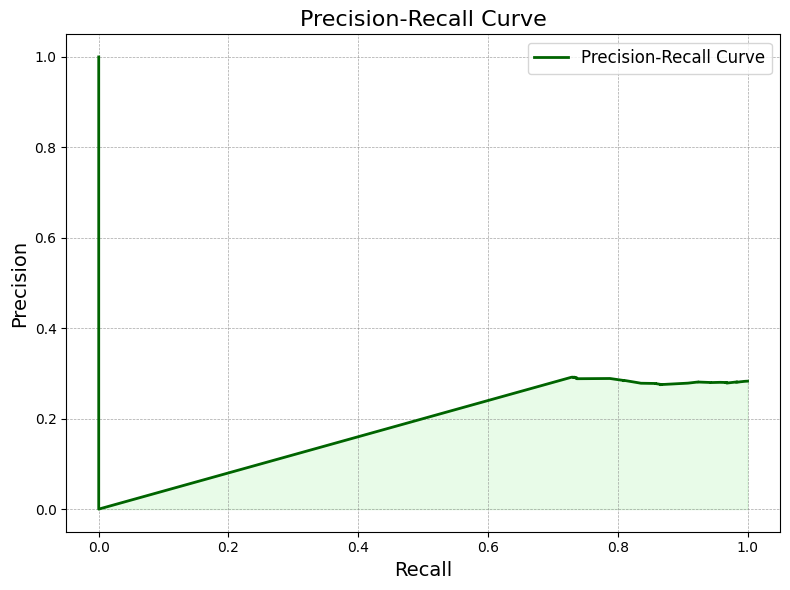

In [44]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


# Generate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, best_model.predict_proba(X_test_transformed)[:, 1])

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="darkgreen", lw=2, label="Precision-Recall Curve")  # Verde scuro
plt.fill_between(recall, precision, alpha=0.2, color="lightgreen")  # Verde chiaro
plt.title("Precision-Recall Curve", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Griglia neutra
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Comment on the results
# The Precision-Recall curve provides insight into the trade-off between precision and recall across different classification thresholds. 
# It is particularly useful for imbalanced datasets. A steep initial decline followed by a plateau would suggest that the model maintains 
# high precision for high recall values, which indicates better performance in correctly predicting positive samples without many false alarms.

The Precision-Recall curve shows an unusual pattern where precision initially increases alongside recall and then stabilizes rather than showing the typical trade-off. This behavior suggests that the model makes increasingly confident positive predictions as more true positives are captured, balancing the increase in false positives.

The high precision at the start indicates that the model is very conservative with its predictions at low recall values, leading to fewer false positives. As recall increases, precision stabilizes, suggesting that the model maintains a relatively consistent balance between true positives and false positives across thresholds.

This pattern could result from an imbalanced dataset or overlapping feature distributions that limit the model's ability to clearly distinguish between classes. The stability in precision also indicates that the model may prioritize both precision and recall evenly, which is beneficial for certain tasks but might reflect limited expressiveness in distinguishing class boundaries.

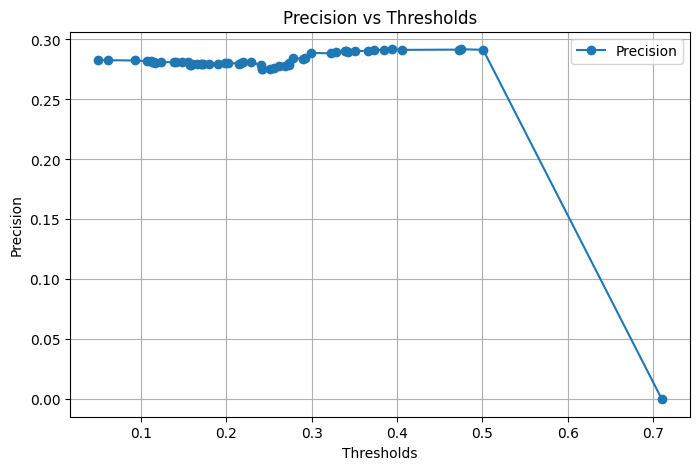

In [45]:
# Graph for Precision
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], marker='o', linestyle='-', label='Precision')
plt.title('Precision vs Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

The analysis of precision across thresholds shows that precision remains stable at lower thresholds but deteriorates sharply as the threshold exceeds 0.5. This suggests that higher thresholds reduce the model's ability to identify positive samples effectively. Based on this behavior, it is critical to balance precision with recall when selecting an optimal threshold, particularly for imbalanced datasets where maximizing precision alone may lead to a significant drop in positive predictions.

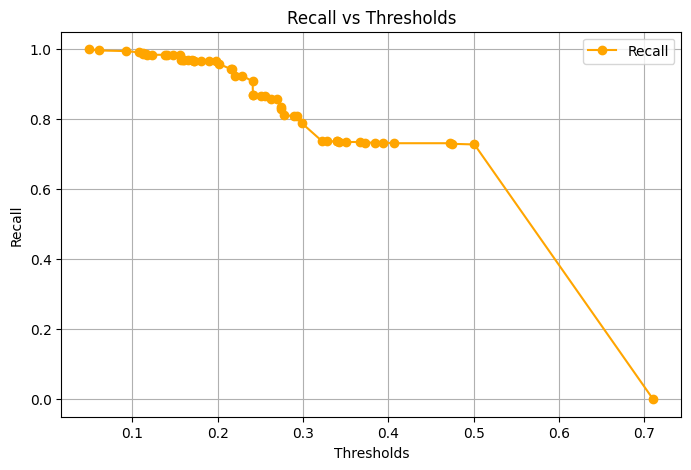

In [46]:
# Graph for Recall
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recall[:-1], marker='o', linestyle='-', color='orange', label='Recall')
plt.title('Recall vs Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()

The recall graph demonstrates a consistent decline as thresholds increase. This behavior is expected since increasing the threshold generally reduces the number of positive predictions, thus lowering recall. The sharp drop-off at the higher end of the threshold range highlights the trade-off between capturing positive instances and minimizing false positives, especially in an imbalanced dataset.

### Confusion matrix

The confusion matrix is a crucial tool for evaluating the performance of the classification model. It compares predicted managerial status with actual labels, helping to identify patterns in the model's errors. By examining the confusion matrix, we can understand the prevalence of false positives (non-managers incorrectly classified as managers) and false negatives (managers incorrectly classified as non-managers), and assess their implications.

- High False Positives: A high number of false positives indicates that the model is overpredicting managerial status, frequently classifying non-managers as managers. This suggests that certain features may be overly influential in the model's decision-making process. If these patterns align with sensitive or inequitable attributes, it could reflect systemic biases within the organization, where non-managers from specific groups are unintentionally favored or overrepresented in predictions. This corresponds to potential inequities in the company structure.

- High False Negatives: On the other hand, a high number of false negatives indicates that the model is underpredicting managerial status, often failing to identify managers correctly. This implies that the model struggles to learn meaningful patterns from the data, potentially due to weak or non-discriminatory relationships between features and managerial roles. Such a scenario might suggest greater equity within the organization, as the dataset does not highlight strong patterns tied to sensitive attributes, or it could reflect inconsistencies in how managerial roles are assigned.

By examining the confusion matrix, I aims to assess whether systemic patterns in the data reflect biases or inequities within the organization. 

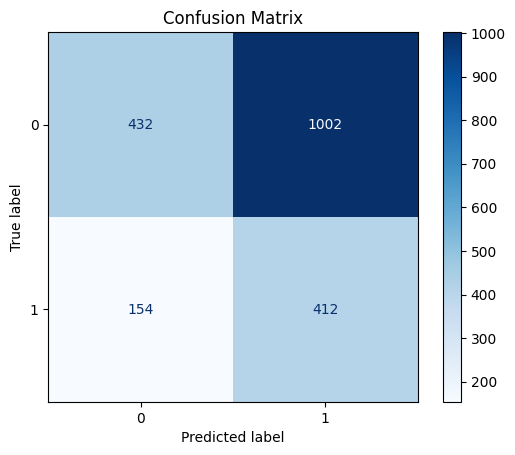

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the pipeline is fitted before making predictions
if not hasattr(best_model_pipeline.named_steps['feature_selection'], 'k_features_'):
    best_model_pipeline.fit(X_train_transformed, y_train)

# Predict the classes using the trained pipeline on the test dataset
y_pred = best_model_pipeline.predict(X_test_transformed)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add a title to the plot
plt.title("Confusion Matrix")
plt.show()

The results:

- True Positives (TP): Managers correctly classified as managers (412).

- True Negatives (TN): Non-managers correctly classified as non-managers (432).

- False Positives (FP): Non-managers incorrectly classified as managers (1002).

- False Negatives (FN): Managers incorrectly classified as non-managers (154).

The model has a high false positive rate, meaning it frequently misclassifies non-managers as managers. The relatively low number of false negatives suggests the model is better at identifying managers than non-managers.

Hence, this value might indicate that certain features are overly influential, leading the model to overpredict managerial status. This pattern could point to implicit biases within the data or the model, suggesting the company’s structure might unintentionally favor certain groups or divisions in decision-making.

### SHAP Analysis

SHAP provides insights into model interpretability by explaining the contribution of each feature to the model's predictions. By decomposing the predicted probability of being a manager, SHAP assigns a value to each feature for every instance, showing how much that feature influenced the prediction positively or negatively.

By visualizing SHAP values, we can understand both global trends, for instance which features matter most overall, and individual predictions, for instance, why the model classified a specific individual as a manager.

SHAP Summary Plot (Bar Chart)

This plot ranks the features based on their average impact on the model's predictions, as measured by their mean absolute SHAP values. It helps identify which features consistently contribute the most across all predictions in the dataset. The x-axis represents the average magnitude of a feature's contribution (SHAP value) to the model’s output.

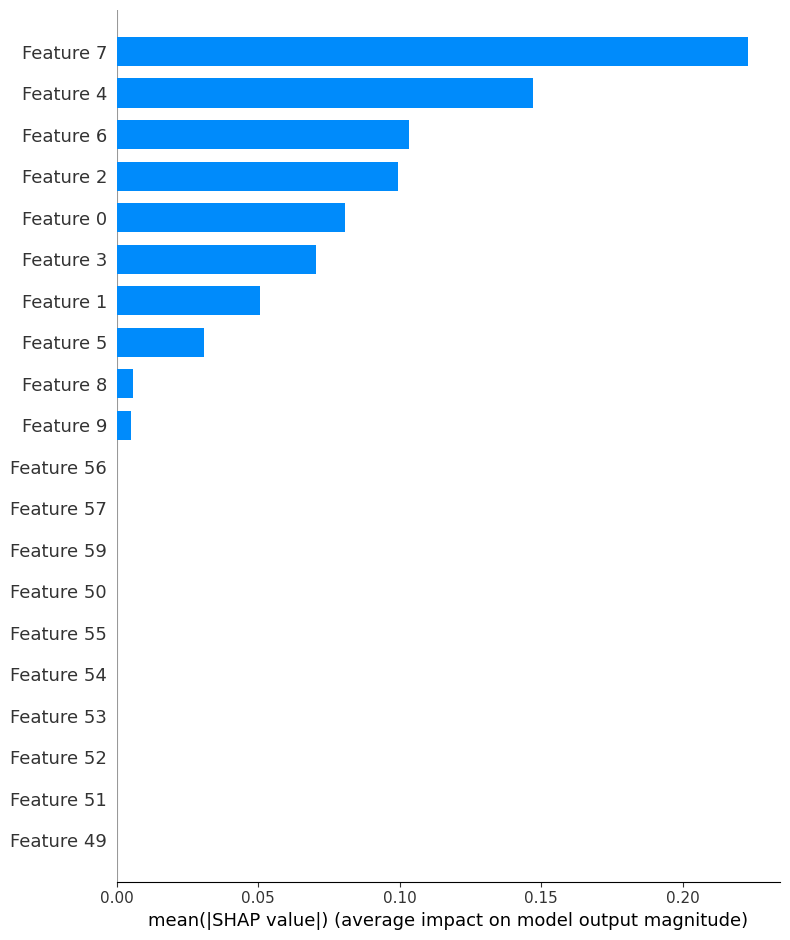

In [48]:
# Ensure the model pipeline is fitted before creating the SHAP explainer
if not hasattr(best_model_pipeline.named_steps['classifier'], "feature_importances_"):
    # Fit the pipeline if not already fitted
    best_model_pipeline.fit(X_train_transformed, y_train)

# Create SHAP explainer for the classifier in the pipeline
explainer = shap.Explainer(best_model_pipeline.named_steps['classifier'], X_train_transformed)

# Calculate SHAP values for the test dataset
shap_values = explainer(X_test_transformed)

# Global feature importance summary (bar plot)
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

In [35]:
# Extracting the feature names from the transformed dataset
feature_names = X_train_df.columns

# Getting the names of the specified features
feature_7 = feature_names[7]  # Feature 7
feature_4 = feature_names[4]  # Feature 4
feature_6 = feature_names[6]  # Feature 6
feature_2 = feature_names[2]  # Feature 2
feature_0 = feature_names[0]  # Feature 0
feature_3 = feature_names[3]  # Feature 3
feature_1 = feature_names[1]  # Feature 1

# Displaying the feature names
feature_7, feature_4, feature_6, feature_2, feature_0, feature_3, feature_1

('Gender_Male',
 'Division_Operations',
 'Division_Sales',
 'Division_IT',
 'Age',
 'Division_Marketing',
 'Division_HR')

The names of the features are:

- Feature 7: Gender Male

- Feature 4: Division Operations

- Feature 6: Division Sales

- Feature 2: Division IT

- Feature 0: Age

- Feature 3: Division Marketing

- Feature 1: Division HR

Features at the top of the plot (Age, Gender_Male) have the most significant impact on predictions. A higher mean SHAP value indicates that the feature plays a prominent role in determining whether an individual is classified as a manager or not. Features toward the bottom have a negligible influence and may not contribute meaningfully to the model.

The Gender Male feature (Feature 7) ranks as the second most impactful, following Age (Feature 0). Its high mean SHAP value suggests that being male strongly affects the model's predictions for managerial positions.

This result aligns with broader organizational trends where men are often overrepresented in leadership roles. The heavy reliance of the model on Gender Male could indicate an implicit bias in the dataset, as the model reflects patterns learned from historical data. The strong influence of this feature raises questions about systemic inequities that may favor men for managerial positions.

SHAP Waterfall Plot (Single Prediction)

This plot explains the contributions of individual features for a single prediction. It shows how each feature pushes the prediction higher (red) or lower (blue) relative to the model’s baseline prediction. The baseline value (E[f(x)]) represents the model's average prediction for all instances. Features with red bars increase the likelihood of the predicted class, being a Manager, while blue bars decrease it. The final prediction (f(x)) is the sum of all feature contributions plus the baseline

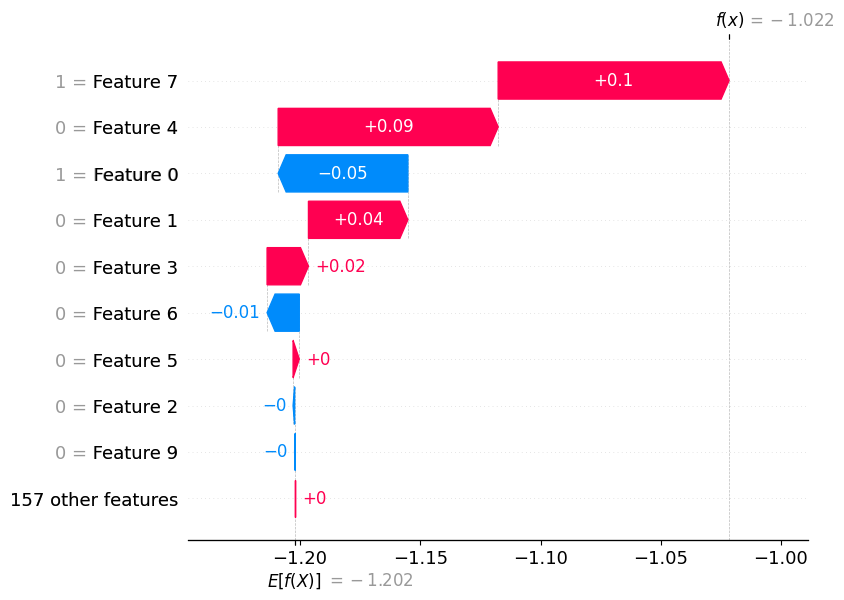

In [50]:
# Detailed contribution of features for a single prediction (e.g., first row in the test set)
shap.waterfall_plot(shap_values[0])

For this specific instance:

- The gender feature (Male) has the strongest positive contribution (+0.1) towards the likelihood of being classified as a manager, followed by Division Operations (+0.09). 

- The feature Age = 1 (30-39 years) contributes negatively (-0.05), slightly reducing the likelihood of being classified as a manager. 

- Division HR (+0.04) and Division Marketing (+0.02) show moderate positive contributions, while Division Sales (-0.01) and other divisions, such as Division IT, have negligible or neutral impact.

The results highlight that the model strongly associates being male and working in certain divisions, such as Operations and HR, with managerial roles, while features like Sales, IT, and age (even in the range of 30-39) play a minor or negative role. This could reflect systemic patterns or biases within the organization, as the historical representation of certain demographics and divisions in managerial positions appears to influence the model's predictions. The notable contribution of gender and division features raises questions about potential inequities in the organizational structure.

SHAP Beeswarm Plot (Global Insights)

This plot illustrates the contribution of each feature to the model's predictions across the dataset, with each dot representing an individual instance. The x-axis shows the SHAP values, reflecting the direction and magnitude of a feature's impact, while the color indicates feature values (blue for low values and red for high values).

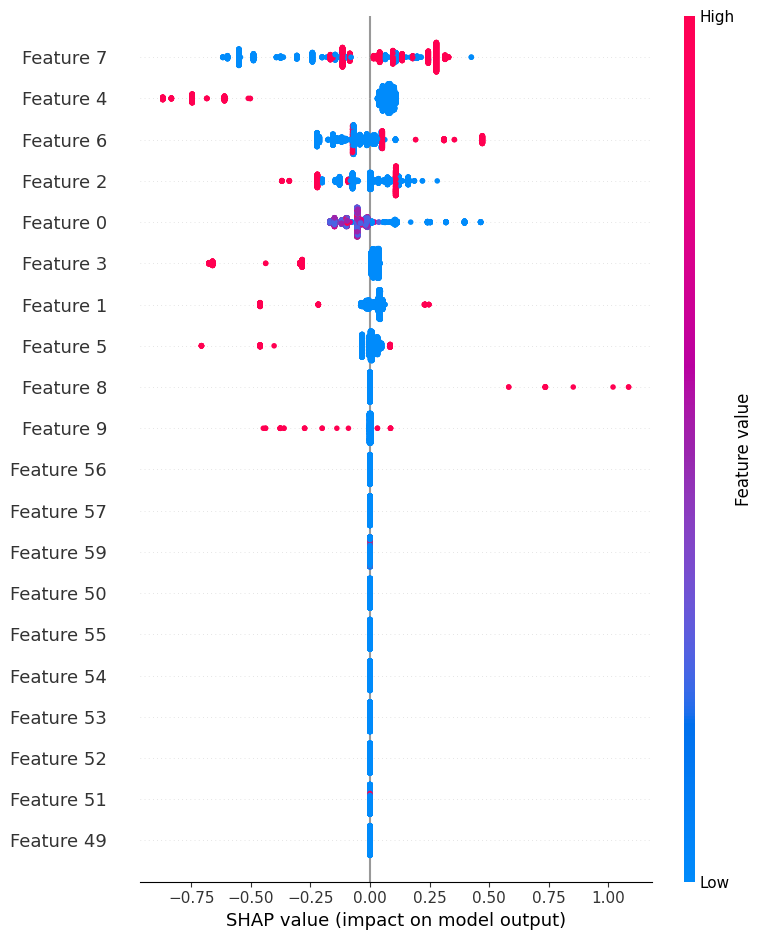

In [51]:
# Detailed SHAP summary for all features
shap.summary_plot(shap_values, X_test_transformed)

Features such as Gender (Male) and Division Operations demonstrate consistent and strong positive contributions when their values are high (red dots), pushing predictions toward being classified as a manager. Similarly, Division HR and Division Marketing show smaller but noticeable positive impacts, suggesting a relatively consistent association with managerial roles.

In contrast, features like Division IT and Age (30-39 years) exhibit more varied patterns, contributing both positively and negatively depending on the instance. This suggests these features have a less uniform influence across the dataset.

Other features like Division Sales and Division R&D show smaller and more neutral impacts, indicating they are less critical to the model's predictions. This variability highlights how different divisions and demographic attributes contribute differently to the likelihood of being classified as a manager, potentially reflecting systemic patterns or biases in the dataset.

## Final Considerations 

The primary goal of this project was to evaluate whether the company was Diverse, Equitable, and Inclusive by determining if an machine learning algorithm could predict, with reasonable performance, who occupies managerial positions. Importantly, sensitive data should not be strong predictors of managerial status, as this could indicate systemic biases.

The analysis started with data visualization to explore the dataset and its distribution. It became evident that certain categories were underrepresented, while others were overrepresented, reflecting potential imbalances within the dataset. Following this, the dataset was preprocessed and transformed into a format suitable for machine learning models. The goal was to identify patterns, if any, that could suggest factors associated with managerial status.

To find the most suitable model, a combination of RandomizedSearchCV and cross-validation was employed. Once the best model was identified, minor refinements were made to optimize its performance further. The results revealed medium-low performance, with an F1-score of approximately 0.4. This score indicates that the model was able to identify some patterns in the data but not overwhelmingly strong ones.

The low performance suggests two possibilities:

- The model's complexity may not have been sufficient to handle the dataset and the task.

- There may indeed be little relationship between the sensitive features and the target variable, managerial status.

A more detailed investigation of the results revealed that the model struggled primarily in identifying non-managers, as evidenced by a significant number of false positives. Further analysis using SHAP revealed that variables such as division and age were the most influential in determining managerial status. This outcome is understandable within the context of organizational hierarchies, where divisions and age often play a role in career advancement.

However, this does not entirely exclude the possibility that the company may lack diversity, equity, and inclusivity. While the model's results indicate that sensitive attributes were not overwhelmingly predictive of managerial status, systemic biases could still be present but not explicitly captured by the algorithm. 

As matter of fact, the underrepresentation of specific categories in the dataset itself suggests that certain groups may face barriers to entry or advancement within the company. This underrepresentation, combined with overrepresentation of other groups, could signal a lack of equitable opportunities.

The findings underscore the importance of interpreting machine learning results cautiously, particularly when addressing sensitive topics like DEI. Although the model's moderate performance suggests a limited direct relationship between sensitive attributes and managerial status, systemic issues could still exist. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f695750e-6751-4cb7-bcaf-e844b5f3a7a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>